In [1]:
# Import necessary libraries
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_path_noelia = '/content/drive/MyDrive/2 CUATRI - MASTER/AI IN RADIOLOGY/final project/USSalivaryGlands/USSalivaryGlands/Imágenes + Labels'
image_path = base_path_noelia

In [5]:
Anonymized_data_df = pd.read_excel(base_path_noelia + '/Anonymized images_student.xlsx')
Anonymized_data_df['Anonymized ID'] = Anonymized_data_df['Anonymized ID'].astype(str).str.zfill(3)
Anonymized_data_df

,Center,Anonymized ID,Patient ID,parotid/submandibular,machine,OMERACT score,Sex,Age at US evaluation,disease duration
0,Udine (Italy),001,1,submandibular,samsung,3,F,72.0,18
1,Udine (Italy),002,1,parotid,samsung,3,F,72.0,18
2,Udine (Italy),003,2,parotid,samsung,3,F,59.0,1
3,Udine (Italy),004,3,parotid,samsung,0,F,65.0,8
4,Udine (Italy),005,3,submandibular,samsung,0,F,65.0,8
...,...,...,...,...,...,...,...,...,...
195,Belgrade (Serbia),214,100,parotid,GE,2,M,19.0,8
196,Belgrade (Serbia),215,101,submandibular,GE,2,F,42.0,4
197,Belgrade (Serbia),216,101,submandibular,GE,2,F,42.0,4
198,Belgrade (Serbia),217,101,parotid,GE,0,F,42.0,4


In [6]:
#JUST SPLIT PATIENT IDs
patient_groups = Anonymized_data_df.groupby('Patient ID')['Anonymized ID'].apply(list)


train_val_patients, test_patients = train_test_split(patient_groups, test_size=0.2, random_state=42)
train_patients, val_patients = train_test_split(train_val_patients, test_size=0.3, random_state=42)

#Lists to stor IDs
train_ids = [image_id for patient_ids in train_patients for image_id in patient_ids]
test_ids = [image_id for patient_ids in test_patients for image_id in patient_ids]
val_ids = [image_id for patient_ids in val_patients for image_id in patient_ids]

# Filter the original df
train_df = Anonymized_data_df[Anonymized_data_df['Anonymized ID'].isin(train_ids)]
test_df = Anonymized_data_df[Anonymized_data_df['Anonymized ID'].isin(test_ids)]
val_df = Anonymized_data_df[Anonymized_data_df['Anonymized ID'].isin(val_ids)]


# Get the image paths and labels for training and test subsets
train_labels = train_df['OMERACT score'].tolist()
test_labels = test_df['OMERACT score'].tolist()
val_labels = val_df['OMERACT score'].tolist()

# Images (path)

image_files = os.listdir(base_path_noelia)
image_files.remove('Anonymized images_student.xlsx')
image_files.remove('labels_students.csv')

# Get the image paths and labels for training and test subsets
train_image_paths = [os.path.join(base_path_noelia, str(image_id) + '.jpg') for image_id in train_df['Anonymized ID']]

test_image_paths = [os.path.join(base_path_noelia, str(image_id) + '.jpg') for image_id in test_df['Anonymized ID']]

val_image_paths = [os.path.join(base_path_noelia, str(image_id) + '.jpg') for image_id in val_df['Anonymized ID']]

# Preprocess

In [7]:
def crop_images(image_paths, target_width, target_height):
    cropped_images = []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get the dimensions of the original image
        height, width, _ = img_rgb.shape

        # Calculate the number of pixels to crop from each side to keep the center
        left_crop = (width - target_width) // 2
        right_crop = width - left_crop - target_width

        # Crop the image while keeping the top intact
        cropped_img = img_rgb[:, left_crop:left_crop + target_width]
        cropped_img = cropped_img[:target_height]
        cropped_images.append(cropped_img)

    return cropped_images


def normalize_images(cropped_images):
    normalized_images = []
    for img in cropped_images:
        # Normalize (0-1)
        img_float = img.astype(np.float32) / 255.0
        normalized_images.append(img_float)
    return normalized_images


def resize_images(images, new_size):
    resized_images = []
    for img in images:
      resized_img = cv2.resize(img, new_size)
      resized_images.append(resized_img)
    return resized_images



In [8]:
#Crop the images proportionally

target_width = 500
target_height = 300
new_size= [224,224]

# Crop images
cropped_train_images = crop_images(train_image_paths, target_width, target_height)
cropped_val_images = crop_images(val_image_paths, target_width, target_height)
cropped_test_images = crop_images(test_image_paths, target_width, target_height)

# Normalize images
normalized_train_images = normalize_images(cropped_train_images)
normalized_val_images = normalize_images(cropped_val_images)
normalized_test_images = normalize_images(cropped_test_images)

# Resize images
resized_train_images = resize_images(normalized_train_images, new_size)
resized_val_images = resize_images(normalized_val_images, new_size)
resized_test_images = resize_images(normalized_test_images, new_size)


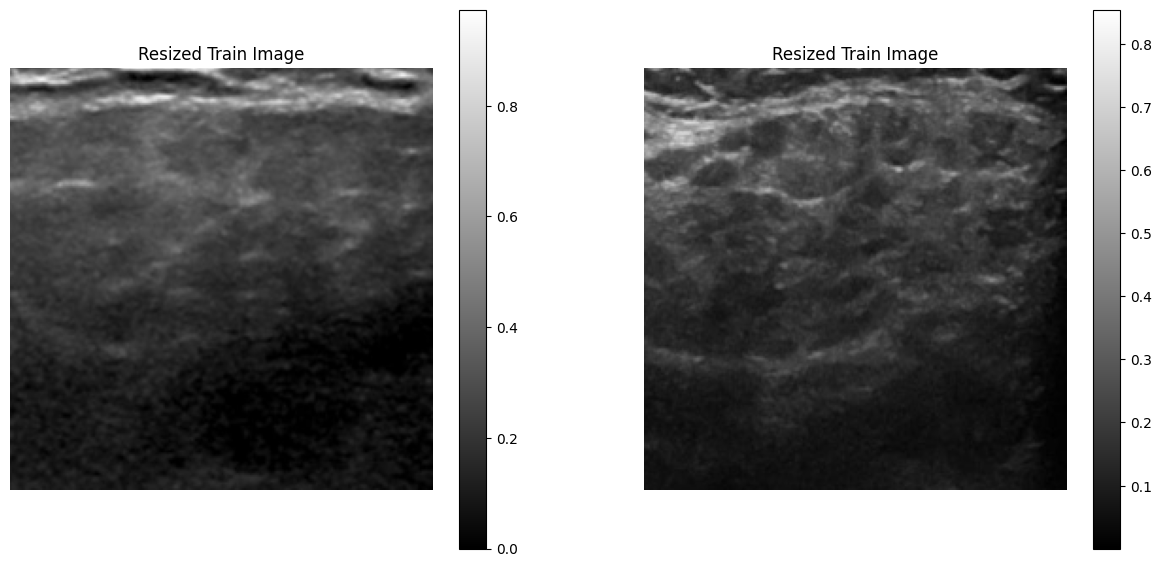

In [9]:
import random
import matplotlib.pyplot as plt

# Show images
def show_images_with_gray_colorbar(images, titles):
    plt.figure(figsize=(15, 7))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.colorbar()
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Randomly select two images
random_resized_train_indices = random.sample(range(len(resized_train_images)), 2)
random_resized_train_images = [resized_train_images[i] for i in random_resized_train_indices]

show_images_with_gray_colorbar(random_resized_train_images, ['Resized Train Image'] * 2)



In [10]:
# Convert to numpy
train_data = np.array(resized_train_images)
val_data = np.array(resized_val_images)
test_data = np.array(resized_test_images)

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

#Check Shapes
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(115, 224, 224, 3)
(48, 224, 224, 3)
(37, 224, 224, 3)


# **MODEL:**

94668760/94668760 [==============================] - 1s 0us/step
Epoch 1/26
15/15 [==============================] - 61s 4s/step - loss: 37.2210 - accuracy: 0.3652 - val_loss: 12.6443 - val_accuracy: 0.5417
Epoch 2/26
15/15 [==============================] - 46s 3s/step - loss: 27.2442 - accuracy: 0.4696 - val_loss: 14.5357 - val_accuracy: 0.5625
Epoch 3/26
15/15 [==============================] - 46s 3s/step - loss: 16.6346 - accuracy: 0.5391 - val_loss: 17.7503 - val_accuracy: 0.5833
Epoch 4/26
15/15 [==============================] - 44s 3s/step - loss: 17.8537 - accuracy: 0.6087 - val_loss: 17.5263 - val_accuracy: 0.4792
Epoch 5/26
15/15 [==============================] - 46s 3s/step - loss: 17.4797 - accuracy: 0.5391 - val_loss: 15.7869 - val_accuracy: 0.6042
Epoch 6/26
15/15 [==============================] - 46s 3s/step - loss: 14.3542 - accuracy: 0.5913 - val_loss: 10.2720 - val_accuracy: 0.6458
Epoch 7/26
15/15 [==============================] - 46s 3s/step - loss: 14.2945 - a

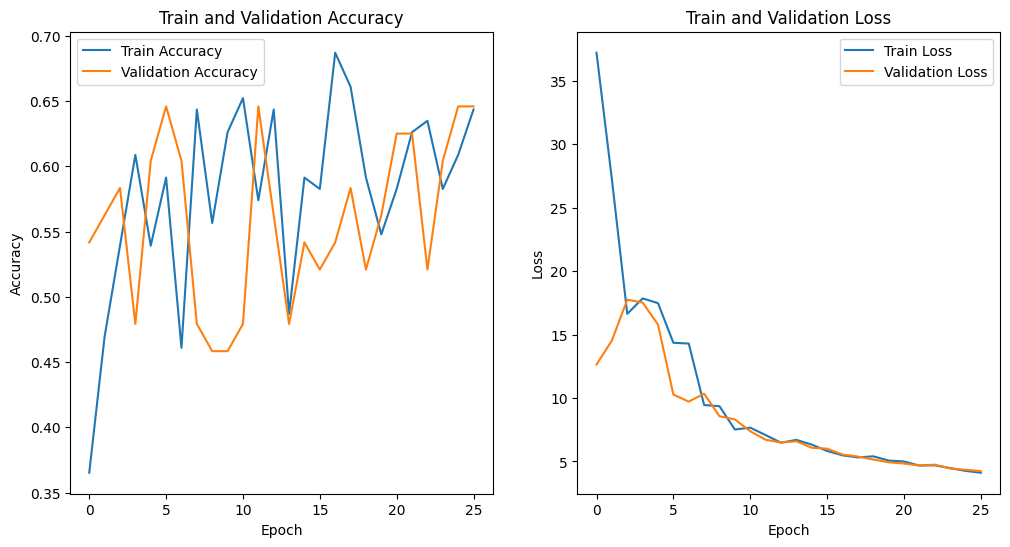

2/2 [==============================] - 5s 750ms/step - loss: 3.9740 - accuracy: 0.6486
Test Accuracy: 0.6486486196517944


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

num_classes = 4

# Comvert to one-hot
train_labels_one_hot = to_categorical(train_labels, num_classes)
val_labels_one_hot = to_categorical(val_labels, num_classes)
test_labels_one_hot = to_categorical(test_labels, num_classes)

# Input shape
input_shape = (224, 224, 3)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator()

# Inputs for the model
train_generator = train_datagen.flow(
    train_data,
    train_labels_one_hot,
    batch_size=8
)

val_generator = val_datagen.flow(
    val_data,
    val_labels_one_hot,
    batch_size=8
)

# Transfer Learning: Resnet50V2 pretrained model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers of the base model (i.e., make them non-trainable)
base_model.trainable = False

# Add additional layers on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Unfreeze the last 8 layers of the base model for fine-tuning
fine_tune_from = -8

for layer in base_model.layers[fine_tune_from:]:
    layer.trainable = True

# Train the model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=26,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator))

# Training and validation loss & accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Test loss & accuracy
test_loss, test_accuracy = model.evaluate(test_data, test_labels_one_hot)
print("Test Accuracy:", test_accuracy)


In [15]:
# Save model
model.save('/content/drive/MyDrive/mi_modelo_completo.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/mi_modelo_completo.h5')

predictions = model.predict(test_data)

predicted_classes = np.argmax(predictions, axis=1)
print(f'Predicted classes: {predicted_classes}')

2/2 [==============================] - 9s 708ms/step
Predicted classes: [3 3 0 0 0 0 3 3 0 0 3 3 3 3 3 0 0 0 3 2 2 0 0 0 0 2 1 0 0 1 3 3 3 1 1 0 1]
